## Enviroment:

Open AI gym [CartPole v0](https://github.com/openai/gym/wiki/CartPole-v0)

### Observation

Type: Box(4)

| Num  | Observation          | Min      | Max     |
| :--- | :------------------- | :------- | :------ |
| 0    | Cart Position        | -2.4     | 2.4     |
| 1    | Cart Velocity        | -Inf     | Inf     |
| 2    | Pole Angle           | ~ -41.8° | ~ 41.8° |
| 3    | Pole Velocity At Tip | -Inf     | Inf     |

### Actions

Type: Discrete(2)

| Num  | Action                 |
| :--- | :--------------------- |
| 0    | Push cart to the left  |
| 1    | Push cart to the right |

Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the cart underneath it

### Reward

Reward is 1 for every step taken, including the termination step

### Starting State

All observations are assigned a uniform random value between ±0.05

### Episode Termination

1. Pole Angle is more than ±12°
2. Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
3. Episode length is greater than 200

### Solved Requirements

Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials

## 1. gym enviroment setup

In [0]:
import gym
import numpy as np

import matplotlib.pyplot as plt
env = gym.make("CartPole-v0")
env.reset()

array([-0.0469722 , -0.01059926, -0.04693691,  0.00855063])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

tf.keras.backend.set_floatx('float64')

In [0]:
# Make sure it is TF2.x
print(tf.__version__)

2.2.0-rc3


In [0]:
ACTION_SPACE_SIZE = env.action_space.n
OBSERVATION_SPACE_SIZE = env.observation_space.shape[0]

# reward discount
GAMMA = 0.95
EPISODES =30000

ep_rewards = []

AGGREGATE_STATS_EVERY = 100

### Network

In [0]:
class Network(keras.Model):
  def __init__(self):
    super().__init__()

    self.model = keras.Sequential(
        [layers.Dense(10, 'relu'),
        # layers.Dense(5,'relu'),
        layers.Dense(ACTION_SPACE_SIZE)]
    )

  def call(self, x):
    out = self.model(x)

    return out

## 3. Agent Class

In [0]:
class PGAgent:

  def __init__(self):
    self.network = Network()
    self.network.build(input_shape = (None,OBSERVATION_SPACE_SIZE))

  def choose_action(self, states):
    states = states.reshape(-1, OBSERVATION_SPACE_SIZE)

    action_logits = self.network(states)
    actions_prob = tf.nn.softmax(action_logits)
    action = np.random.choice(len(actions_prob.numpy()[0]),p=actions_prob.numpy()[0])
    return action
  def train(self, states, actions, rewards):
    
    discounted_episode_rewards = self.discount_rewards(rewards)

    # print("s:{}, a:{}, r:{}".format(self.states , self.actions, self.discounted_episode_rewards))

    optimizer = keras.optimizers.Adam(0.001)
    
    with tf.GradientTape() as tape:
      action_logits = self.network(states)
      cross_entropy = tf.losses.sparse_categorical_crossentropy(y_true=actions, 
                                                                   y_pred=action_logits,
                                                                   from_logits=True )
      loss = tf.reduce_mean(cross_entropy * discounted_episode_rewards)

    grads = tape.gradient(loss, self.network.variables)
    optimizer.apply_gradients(zip(grads, self.network.variables))


  def discount_rewards(self,rewards):
        # discount episode rewards
        discounted_ep_rs = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * GAMMA + rewards[t]
            discounted_ep_rs[t] = running_add

        # normalize episode rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs
  

In [0]:
agent = PGAgent()

## 4. Train the agent

In [0]:
# from visdom import Visdom

# vis = Visdom()

In [0]:
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

In [0]:
# Iterate over episodes
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
    # Restarting episode - reset episode states,actions, and rewards 
    episode_states, episode_actions, episode_rewards = [],[],[]
    
    #Reset single step reward
    episode_reward = 0

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # print("current state", current_state)
        action = agent.choose_action(current_state)
        next_state, reward, done, _ = env.step(action)

        # Store [s a r]
        episode_states.append(current_state)
        episode_actions.append(action)
        episode_rewards.append(reward)


        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

#         if not episode % AGGREGATE_STATS_EVERY:
#             env.render()

        current_state = next_state

    agent.train(np.vstack(episode_states), np.array(episode_actions), np.array(episode_rewards))
    
    # vis.line([episode_reward],[episode],win='ep_rewards',update='append')
    
    # Append episode reward to a list and log rewards (every given number of episodes)
    ep_rewards.append(episode_reward)

    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        
        # vis.line([[average_reward,min_reward,max_reward]], [episode], win='aggr_ep_reward',
        #          update='append',
        #          opts=dict(title='aggr_ep_reward',legend=['avg','min','max']))

        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['min'].append(min_reward)
        aggr_ep_rewards['max'].append(max_reward)
        
#         agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)


100%|##########| 30000/30000 [2:33:55<00:00,  3.25episodes/s]


## 5. Plot episodes vs rewards

Text(0, 0.5, 'Rewards')

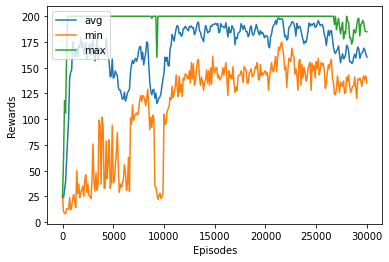

In [0]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### Rendering Test

In [0]:
done = False
state = env.reset()
for i in range(500):
# while not done:
    action = agent.choose_action(state)
    next_state, _, done, _ = env.step(action)
    state = next_state
    env.render()

env.close()
    